<a href="https://colab.research.google.com/github/mattsmiths/biol470/blob/main/week3/wormmi_wormmi_2026.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [87]:
import os
import numpy as np
from matplotlib import pyplot as plt
import math
import cv2 as cv
import shutil

In [88]:
#@title Worm Parameters
time_duration = 400#@param {type:"integer"}
odor_molecules = 12 #@param {type:"integer"}
stimulus_timing = 360 #@param {type:"integer"}
N_FRAMES = time_duration
bunchNumber = odor_molecules

In [101]:
# Nervous system (LIF neurons; Left & Right)
V_rest = -65.0                         # mV
V_reset = -60.0                        # mV
V_th = -50.0                           # mV
V_min_plot = -70.0                     # plot scale min
V_max_plot = -45.0                     # plot scale max
tau_m_frames = 20.0                    # membrane time constant (frames)
alpha = math.exp(-1.0 / tau_m_frames)  # decay factor per frame
EPSP_amp_base = 4.0                    # mV per contact; scaled by odor intensity (0..1)
mem_noise_std = 0.5                    # mV noise
refractory_frames = 5                  # frames of absolute refractory

# Motor burst upon spike
AP_turn_omega = 0.26                   # rad/frame when spiking
AP_turn_duration = 6                   # frames


# Starting point for wormmiii
starting_point = [100,500]

In [92]:

#@title Baseline wormmi wormmi
"""
Simulated worm with a minimal nervous system:
- Odor packets (moving circles) form a sparse, dynamic odor field.
- Two lateral sensors produce EPSPs during odor contact.
- Each side has a leaky-integrate-and-fire (LIF) neuron; threshold crossings produce spikes.
- Spikes add transient angular velocity (motor turns) to the baseline control:
    * Baseline control = sigmoid-based turning in odor + casting when not in contact
- Membrane potentials (Left/Right) are plotted at the top of the video as scrolling traces.
- Frames are written to /content/ims/%04d.jpg

Dependencies: numpy, opencv-python
"""
import os
import math
import numpy as np
import cv2 as cv

# -----------------------
# PARAMETERS (tweak here)
# -----------------------
#np.random.seed(4)

# World canvas (odor/agent)
H, W = 1000, 1000                     # world dimensions
#N_FRAMES = 700

if os.path.isdir('/content/ims/'):
  shutil.rmtree('/content/ims/')
OUTDIR = "/content/ims"
os.makedirs(OUTDIR, exist_ok=True)

# Plot (membrane potentials) panel at top
PLOT_H = 160                           # height for traces panel
BG_COLOR = (0, 0, 0)                   # black background
LEFT_COLOR = (255, 255, 255)               # BGR: blue trace for Left neuron
RIGHT_COLOR = (255, 200, 255)              # red trace for Right neuron
AXIS_COLOR = (160, 160, 160)           # grid/axis color
TEXT_COLOR = (220, 220, 220)

# Odor packet (moving circles) params
#bunchNumber = 8                        # spawn per release event
rFreq = 14                             # initial release period (frames)
min_rFreq = 4                          # min period (max rate)
packet_radius = 4
packet_speed_y = -1.2                  # upward drift (pixel/frame)
packet_jitter_xy = 0.8                 # extra jitter
width1 = 1.0                           # horizontal spread
spawn_center_x = 500
spawn_start_y = 950
odor_value_per_pixel = 1.0             # scale of odor intensity per pixel

# Worm kinematics

worm_pos = np.array([starting_point[0], starting_point[1]], dtype=np.float32)
worm_heading = 0.0 #- (np.pi*1.5)                    # radians (0 = +x)
worm_speed = 3.0
wall_bounce = True

# Sensors geometry
sensor_offset = 10.0                   # distance from head
sensor_angle_deg = 35.0                # +/- relative to heading
sensor_sample_radius = 2               # sample neighborhood radius (px)

# Baseline control: casting & sigmoid chemotaxis
cast_freq = 0.035
cast_amp_omega = 0.10
heading_noise_std = np.random.rand()*0.5 #0.02
gain = 3.0                             # sigmoid steepness for subthreshold orienting
omega_max = 0.4                       # max angular velocity from sigmoid
odor_noise_std = 0.35                  # noise in sigmoid input

# Nervous system (LIF neurons; Left & Right)
#V_rest = -65.0                         # mV
#V_reset = -60.0                        # mV
#V_th = -50.0                           # mV
#V_min_plot = -70.0                     # plot scale min
#V_max_plot = -45.0                     # plot scale max
#tau_m_frames = 20.0                    # membrane time constant (frames)
#alpha = math.exp(-1.0 / tau_m_frames)  # decay factor per frame
#EPSP_amp_base = 4.0                    # mV per contact; scaled by odor intensity (0..1)
#mem_noise_std = 0.5                    # mV noise
#refractory_frames = 5                  # frames of absolute refractory

# Motor burst upon spike
#AP_turn_omega = 0.26                   # rad/frame when spiking
#AP_turn_duration = 6                   # frames

# Trail rendering
trail_len = 16

# -----------------------
# Helpers
# -----------------------
def sigmoid(z: float) -> float:
    return 1.0 / (1.0 + math.exp(-z))

def rot(v, ang):
    c, s = math.cos(ang), math.sin(ang)
    return np.array([c*v[0] - s*v[1], s*v[0] + c*v[1]], dtype=np.float32)

def reflect_heading_on_edges(pos, heading, W, H, margin=5):
    x, y = pos
    bounced = False
    if x < margin:
        heading = math.pi - heading
        pos[0] = margin
        bounced = True
    elif x >= W - margin:
        heading = math.pi - heading
        pos[0] = W - margin - 1
        bounced = True

    if y < margin:
        heading = -heading
        pos[1] = margin
        bounced = True
    elif y >= H - margin:
        heading = -heading
        pos[1] = H - margin - 1
        bounced = True

    if bounced:
        heading = (heading + math.pi) % (2*math.pi) - math.pi
    return pos, heading

def sample_odor_avg(field, x, y, r):
    """
    Return average odor intensity (0..1) over a small (2r+1) x (2r+1) patch centered on (x,y).
    """
    xi, yi = int(round(x)), int(round(y))
    x0, x1 = max(0, xi - r), min(field.shape[1], xi + r + 1)
    y0, y1 = max(0, yi - r), min(field.shape[0], yi + r + 1)
    patch = field[y0:y1, x0:x1]
    if patch.size == 0:
        return 0.0
    return float(patch.mean() / 255.0)

def map_v_to_y(v, plot_h):
    """
    Map membrane potential v (mV) to y coordinate (pixels) in [0, plot_h-1],
    with higher potentials near top (smaller y).
    """
    v_clamped = max(V_min_plot, min(V_max_plot, v))
    frac = (v_clamped - V_min_plot) / (V_max_plot - V_min_plot + 1e-9)
    return int(round((1.0 - frac) * (plot_h - 1)))

# -----------------------
# Odor packets
# -----------------------
packets = {}   # id -> dict(x, y, vx, vy)
next_id = 0

def spawn_bunch():
    global next_id
    for _ in range(bunchNumber):
        x = spawn_center_x + np.random.randn() * 8.0
        y = spawn_start_y + np.random.randn() * 5.0
        vx = np.random.uniform(-width1, width1)
        vy = packet_speed_y * (0.7 + 0.6*np.random.rand())
        packets[next_id] = {"x": float(x), "y": float(y), "vx": float(vx), "vy": float(vy)}
        next_id += 1

# Initial release
spawn_bunch()

# -----------------------
# Nervous system state
# -----------------------
V_L = V_rest
V_R = V_rest
ref_L = 0
ref_R = 0
burst_L = 0    # frames remaining for AP motor burst
burst_R = 0

dist_store = [] # for tracking distance from source

# For plotting: keep last W samples for both traces
hist_L = []
hist_R = []
spike_marks_L = []  # boolean flags matching hist indices for spikes
spike_marks_R = []

# -----------------------
# Simulation
# -----------------------
trail = [tuple(worm_pos)]
rFreq_current = rFreq

for t in range(N_FRAMES):
    # Increase release rate gradually
    # Releasing at increasing frequency until 100 frames
    if (t % 10 == 0) and (t > 100) and rFreq_current > min_rFreq:
        rFreq_current -= 1

    # Releasing until 280
    if t % rFreq_current == 0 and t < stimulus_timing:
        spawn_bunch()

    # --- Build odor field (green) ---
    odor_field = np.zeros((H, W), dtype=np.uint8)
    to_delete = []
    for pid, p in packets.items():
        # jitter
        p["vx"] += np.random.randn() * 0.1 + np.random.uniform(-packet_jitter_xy, packet_jitter_xy) * 0.1
        p["vy"] += np.random.randn() * 0.05 + np.random.uniform(-packet_jitter_xy, packet_jitter_xy) * 0.1

        p["x"] += p["vx"]
        p["y"] += p["vy"]

        x_i, y_i = int(round(p["x"])), int(round(p["y"]))
        if 0 <= x_i < W and 0 <= y_i < H:
            cv.circle(odor_field, (x_i, y_i), packet_radius, 255, -1)
        else:
            to_delete.append(pid)

    for pid in to_delete:
        packets.pop(pid, None)

    # --- Worm sensors ---
    dir_vec = np.array([math.cos(worm_heading), math.sin(worm_heading)], dtype=np.float32)
    sensor_angle = math.radians(sensor_angle_deg)
    left_dir = rot(dir_vec, +sensor_angle)
    right_dir = rot(dir_vec, -sensor_angle)
    left_sensor = worm_pos + sensor_offset * left_dir
    right_sensor = worm_pos + sensor_offset * right_dir

    # Average odor intensity (0..1) around each sensor
    odor_L = sample_odor_avg(odor_field, left_sensor[0], left_sensor[1], sensor_sample_radius)
    odor_R = sample_odor_avg(odor_field, right_sensor[0], right_sensor[1], sensor_sample_radius)
    in_contact_any = (odor_L + odor_R) > 1e-6

    # -----------------------
    # Nervous system update (LIF)
    # -----------------------
    # Left neuron
    spk_L = False
    if ref_L > 0:
        ref_L -= 1
        # Hold near reset during refractory, with slight decay to rest
        V_L = V_reset + (V_L - V_reset) * alpha
    else:
        # Leaky integration towards rest + EPSP(s) + noise
        V_L = V_rest + (V_L - V_rest) * alpha
        V_L += EPSP_amp_base * odor_L * odor_value_per_pixel
        V_L += np.random.randn() * mem_noise_std
        if V_L >= V_th:
            spk_L = True
            V_L = V_reset
            ref_L = refractory_frames
            burst_L = AP_turn_duration  # motor burst

    # Right neuron
    spk_R = False
    if ref_R > 0:
        ref_R -= 1
        V_R = V_reset + (V_R - V_reset) * alpha
    else:
        V_R = V_rest + (V_R - V_rest) * alpha
        V_R += EPSP_amp_base * odor_R * odor_value_per_pixel
        V_R += np.random.randn() * mem_noise_std
        if V_R >= V_th:
            spk_R = True
            V_R = V_reset
            ref_R = refractory_frames
            burst_R = AP_turn_duration

    # Save potentials history for plotting (limit to width W)
    hist_L.append(V_L)
    hist_R.append(V_R)
    spike_marks_L.append(spk_L)
    spike_marks_R.append(spk_R)
    if len(hist_L) > W:
        hist_L.pop(0); hist_R.pop(0)
        spike_marks_L.pop(0); spike_marks_R.pop(0)

    # -----------------------
    # Motor control
    # -----------------------

    # Baseline control (subthreshold): sigmoid chemotaxis if in contact, else casting
    if in_contact_any:
        d_odor = (odor_R - odor_L)
        noisy_input = gain * d_odor + np.random.randn() * odor_noise_std
        turn_unit = 2.0 * sigmoid(noisy_input) - 1.0
        #omega_base = omega_max * turn_unit
    else:
        omega_base = cast_amp_omega * math.sin(2.0 * math.pi * cast_freq * t)
        omega_base += np.random.randn() * heading_noise_std

    # AP-driven motor bursts
    omega_ap = 0.0
    if burst_R > 0:
        omega_ap -= AP_turn_omega
        burst_R -= 1
    if burst_L > 0:
        omega_ap += AP_turn_omega#-= AP_turn_omega
        burst_L -= 1

    # Total angular velocity
    omega = omega_base + omega_ap

    # Kinematics
    worm_heading += omega
    worm_pos += worm_speed * np.array([math.cos(worm_heading), math.sin(worm_heading)], dtype=np.float32)

    if wall_bounce:
        worm_pos, worm_heading = reflect_heading_on_edges(worm_pos, worm_heading, W, H)
    dist_store.append(np.linalg.norm(worm_pos-(spawn_center_x,spawn_start_y)))
    # Trail
    trail.append(tuple(worm_pos))
    if len(trail) > trail_len:
        trail.pop(0)

    # -----------------------
    # RENDER WORLD (bottom)
    # -----------------------
    world = np.zeros((H, W, 3), dtype=np.uint8)
    # Odor: green
    world[:, :, 1] = odor_field

    # Trail: red
    for (tx, ty) in trail[:-1]:
        cv.circle(world, (int(tx), int(ty)), 4, (0, 0, 255), -1)

    # Head: red, brighter
    hx, hy = int(round(worm_pos[0])), int(round(worm_pos[1]))
    cv.circle(world, (hx, hy), 5, (0, 0, 255), -1)

    # Sensors: white
    lsx, lsy = int(round(left_sensor[0])), int(round(left_sensor[1]))
    rsx, rsy = int(round(right_sensor[0])), int(round(right_sensor[1]))
    if 0 <= lsx < W and 0 <= lsy < H:
        cv.circle(world, (lsx, lsy), 3, (255, 255, 255), -1)
    if 0 <= rsx < W and 0 <= rsy < H:
        cv.circle(world, (rsx, rsy), 3, (255, 255, 255), -1)

    # -----------------------
    # RENDER PLOT (top)
    # -----------------------
    frame = np.zeros((H + PLOT_H, W, 3), dtype=np.uint8)
    # Paste world into bottom
    frame[PLOT_H:, :, :] = world

    # Draw axes & labels
    plot = frame[0:PLOT_H, :, :]
    # Background (already black)
    # Threshold (dashed)
    y_th = map_v_to_y(V_th, PLOT_H)
    for x in range(0, W, 10):
        plot[y_th:y_th+1, x:x+5, :] = AXIS_COLOR
    # Rest (dotted)
    y_rest = map_v_to_y(V_rest, PLOT_H)
    for x in range(0, W, 6):
        plot[y_rest:y_rest+1, x:x+2, :] = (110, 110, 110)

    # Current values text (top-left)
    cv.putText(plot, f"L: {V_L:5.1f} mV", (10, 22), cv.FONT_HERSHEY_SIMPLEX, 0.6, LEFT_COLOR, 1, cv.LINE_AA)
    cv.putText(plot, f"R: {V_R:5.1f} mV", (10, 44), cv.FONT_HERSHEY_SIMPLEX, 0.6, RIGHT_COLOR, 1, cv.LINE_AA)
    cv.putText(plot, "Membrane potentials (top)", (10, PLOT_H-8),
               cv.FONT_HERSHEY_SIMPLEX, 0.5, TEXT_COLOR, 1, cv.LINE_AA)

    # Draw traces (scrolling left->right)
    n_pts = len(hist_L)
    if n_pts >= 2:
        # Build polylines for left and right
        pts_L = np.zeros((n_pts, 1, 2), dtype=np.int32)
        pts_R = np.zeros((n_pts, 1, 2), dtype=np.int32)
        for i in range(n_pts):
            x = W - n_pts + i  # right-aligned scrolling
            yL = map_v_to_y(hist_L[i], PLOT_H)
            yR = map_v_to_y(hist_R[i], PLOT_H)
            pts_L[i, 0, :] = (x, yL)
            pts_R[i, 0, :] = (x, yR)
        cv.polylines(plot, [pts_L], isClosed=False, color=LEFT_COLOR, thickness=2)
        cv.polylines(plot, [pts_R], isClosed=False, color=RIGHT_COLOR, thickness=2)

        # Mark spikes at the right margin with short vertical ticks
        # We place them at the x of the most recent sample (right edge)
        x_now = W - 1
        if spike_marks_L[-1]:
            y = map_v_to_y(hist_L[-1], PLOT_H)
            cv.line(plot, (x_now, y-8), (x_now, y+8), LEFT_COLOR, 2)
        if spike_marks_R[-1]:
            y = map_v_to_y(hist_R[-1], PLOT_H)
            cv.line(plot, (x_now, y-8), (x_now, y+8), RIGHT_COLOR, 2)

    # Save frame
    cv.imwrite(os.path.join(OUTDIR, f"{t:04d}.jpg"), frame)


In [93]:
#@title Generate Video
import glob
import datetime

t1 = datetime.datetime.now().isoformat()
t2 = t1.split('.')[0]
vidOut = cv.VideoWriter('wurmmi_wurmmi_%s.avi'%t2,cv.VideoWriter_fourcc('M','J','P','G'), 16, (1000,1160))
ffs = glob.glob('/content/ims/*.jpg')
ffs.sort()

for ele in ffs:
  img = cv.imread(ele)
  vidOut.write(img)

vidOut.release()

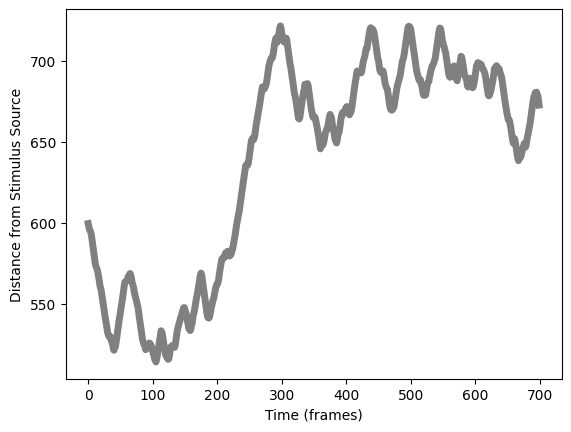

In [ ]:
plt.figure()
plt.plot(dist_store,linewidth=5,color=(0.5,0.5,0.5))
plt.ylabel('Distance from Stimulus Source')
plt.xlabel('Time (frames)')
plt.savefig('Dist_timeseries_1.png')

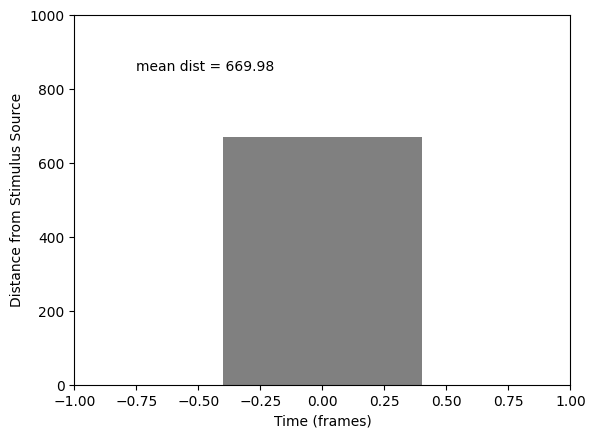

In [ ]:
plt.figure()
plt.bar(0,np.nanmean(dist_store),color=(0.5,0.5,0.5))
plt.xlim([-1,1])
plt.ylim([0,1000])
plt.text(-0.75,850,'mean dist = '+str(np.round(np.nanmean(dist_store),2)))
plt.ylabel('Distance from Stimulus Source')
plt.xlabel('Time (frames)')
plt.savefig('Mean_dist_more_odors_lowNoise_1.png')

# Testing parameter variability

In [154]:
# Nervous system (LIF neurons; Left & Right)
V_rest = -65.0                         # mV
V_reset = -60.0                        # mV
V_th = -50.0                           # mV
V_min_plot = -70.0                     # plot scale min
V_max_plot = -45.0                     # plot scale max
tau_m_frames = 5.0                    # membrane time constant (frames)
alpha = math.exp(-1.0 / tau_m_frames)  # decay factor per frame
EPSP_amp_base = 10.0                    # mV per contact; scaled by odor intensity (0..1)
mem_noise_std = 0.5                    # mV noise
refractory_frames = 20                  # frames of absolute refractory

# Motor burst upon spike
AP_turn_omega = 0.26                   # rad/frame when spiking
AP_turn_duration = 6                   # frames


# Starting point for wormmiii
starting_point = [100,500]

In [158]:
#@title How many iterations?
loops = 20#@param {type:"integer"}


In [159]:

#@title Looping wormmi wormmi
"""
Simulated worm with a minimal nervous system:
- Odor packets (moving circles) form a sparse, dynamic odor field.
- Two lateral sensors produce EPSPs during odor contact.
- Each side has a leaky-integrate-and-fire (LIF) neuron; threshold crossings produce spikes.
- Spikes add transient angular velocity (motor turns) to the baseline control:
    * Baseline control = sigmoid-based turning in odor + casting when not in contact
- Membrane potentials (Left/Right) are plotted at the top of the video as scrolling traces.
- Frames are written to /content/ims/%04d.jpg

Dependencies: numpy, opencv-python
"""
import os
import math
import numpy as np
import cv2 as cv


mean_loop = []

for interaction_step in np.arange(0,loops):


  # -----------------------
  # PARAMETERS (tweak here)
  # -----------------------
  #np.random.seed(4)

  # World canvas (odor/agent)
  H, W = 1000, 1000                     # world dimensions
  #N_FRAMES = 700

  if os.path.isdir('/content/ims/'):
    shutil.rmtree('/content/ims/')
  OUTDIR = "/content/ims"
  os.makedirs(OUTDIR, exist_ok=True)

  # Plot (membrane potentials) panel at top
  PLOT_H = 160                           # height for traces panel
  BG_COLOR = (0, 0, 0)                   # black background
  LEFT_COLOR = (255, 255, 255)               # BGR: blue trace for Left neuron
  RIGHT_COLOR = (255, 200, 255)              # red trace for Right neuron
  AXIS_COLOR = (160, 160, 160)           # grid/axis color
  TEXT_COLOR = (220, 220, 220)

  # Odor packet (moving circles) params
  #bunchNumber = 8                        # spawn per release event
  rFreq = 14                             # initial release period (frames)
  min_rFreq = 4                          # min period (max rate)
  packet_radius = 4
  packet_speed_y = -1.2                  # upward drift (pixel/frame)
  packet_jitter_xy = 0.8                 # extra jitter
  width1 = 1.0                           # horizontal spread
  spawn_center_x = 500
  spawn_start_y = 950
  odor_value_per_pixel = 1.0             # scale of odor intensity per pixel

  # Worm kinematics

  worm_pos = np.array([starting_point[0], starting_point[1]], dtype=np.float32)
  worm_heading = 0.0 #- (np.pi*1.5)                    # radians (0 = +x)
  worm_speed = 3.0
  wall_bounce = True

  # Sensors geometry
  sensor_offset = 10.0                   # distance from head
  sensor_angle_deg = 35.0                # +/- relative to heading
  sensor_sample_radius = 2               # sample neighborhood radius (px)

  # Baseline control: casting & sigmoid chemotaxis
  cast_freq = 0.035
  cast_amp_omega = 0.10
  heading_noise_std = np.random.rand()*0.5 #0.02
  gain = 3.0                             # sigmoid steepness for subthreshold orienting
  omega_max = 0.4                       # max angular velocity from sigmoid
  odor_noise_std = 0.35                  # noise in sigmoid input

  # Nervous system (LIF neurons; Left & Right)
  #V_rest = -65.0                         # mV
  #V_reset = -60.0                        # mV
  #V_th = -50.0                           # mV
  #V_min_plot = -70.0                     # plot scale min
  #V_max_plot = -45.0                     # plot scale max
  #tau_m_frames = 20.0                    # membrane time constant (frames)
  #alpha = math.exp(-1.0 / tau_m_frames)  # decay factor per frame
  #EPSP_amp_base = 4.0                    # mV per contact; scaled by odor intensity (0..1)
  #mem_noise_std = 0.5                    # mV noise
  #refractory_frames = 5                  # frames of absolute refractory

  # Motor burst upon spike
  #AP_turn_omega = 0.26                   # rad/frame when spiking
  #AP_turn_duration = 6                   # frames

  # Trail rendering
  trail_len = 16

  # -----------------------
  # Helpers
  # -----------------------
  def sigmoid(z: float) -> float:
      return 1.0 / (1.0 + math.exp(-z))

  def rot(v, ang):
      c, s = math.cos(ang), math.sin(ang)
      return np.array([c*v[0] - s*v[1], s*v[0] + c*v[1]], dtype=np.float32)

  def reflect_heading_on_edges(pos, heading, W, H, margin=5):
      x, y = pos
      bounced = False
      if x < margin:
          heading = math.pi - heading
          pos[0] = margin
          bounced = True
      elif x >= W - margin:
          heading = math.pi - heading
          pos[0] = W - margin - 1
          bounced = True

      if y < margin:
          heading = -heading
          pos[1] = margin
          bounced = True
      elif y >= H - margin:
          heading = -heading
          pos[1] = H - margin - 1
          bounced = True

      if bounced:
          heading = (heading + math.pi) % (2*math.pi) - math.pi
      return pos, heading

  def sample_odor_avg(field, x, y, r):
      """
      Return average odor intensity (0..1) over a small (2r+1) x (2r+1) patch centered on (x,y).
      """
      xi, yi = int(round(x)), int(round(y))
      x0, x1 = max(0, xi - r), min(field.shape[1], xi + r + 1)
      y0, y1 = max(0, yi - r), min(field.shape[0], yi + r + 1)
      patch = field[y0:y1, x0:x1]
      if patch.size == 0:
          return 0.0
      return float(patch.mean() / 255.0)

  def map_v_to_y(v, plot_h):
      """
      Map membrane potential v (mV) to y coordinate (pixels) in [0, plot_h-1],
      with higher potentials near top (smaller y).
      """
      v_clamped = max(V_min_plot, min(V_max_plot, v))
      frac = (v_clamped - V_min_plot) / (V_max_plot - V_min_plot + 1e-9)
      return int(round((1.0 - frac) * (plot_h - 1)))

  # -----------------------
  # Odor packets
  # -----------------------
  packets = {}   # id -> dict(x, y, vx, vy)
  next_id = 0

  def spawn_bunch():
      global next_id
      for _ in range(bunchNumber):
          x = spawn_center_x + np.random.randn() * 8.0
          y = spawn_start_y + np.random.randn() * 5.0
          vx = np.random.uniform(-width1, width1)
          vy = packet_speed_y * (0.7 + 0.6*np.random.rand())
          packets[next_id] = {"x": float(x), "y": float(y), "vx": float(vx), "vy": float(vy)}
          next_id += 1

  # Initial release
  spawn_bunch()

  # -----------------------
  # Nervous system state
  # -----------------------
  V_L = V_rest
  V_R = V_rest
  ref_L = 0
  ref_R = 0
  burst_L = 0    # frames remaining for AP motor burst
  burst_R = 0

  dist_store = [] # for tracking distance from source

  # For plotting: keep last W samples for both traces
  hist_L = []
  hist_R = []
  spike_marks_L = []  # boolean flags matching hist indices for spikes
  spike_marks_R = []

  # -----------------------
  # Simulation
  # -----------------------
  trail = [tuple(worm_pos)]
  rFreq_current = rFreq

  for t in range(N_FRAMES):
      # Increase release rate gradually
      # Releasing at increasing frequency until 100 frames
      if (t % 10 == 0) and (t > 100) and rFreq_current > min_rFreq:
          rFreq_current -= 1

      # Releasing until 280
      if t % rFreq_current == 0 and t < stimulus_timing:
          spawn_bunch()

      # --- Build odor field (green) ---
      odor_field = np.zeros((H, W), dtype=np.uint8)
      to_delete = []
      for pid, p in packets.items():
          # jitter
          p["vx"] += np.random.randn() * 0.1 + np.random.uniform(-packet_jitter_xy, packet_jitter_xy) * 0.1
          p["vy"] += np.random.randn() * 0.05 + np.random.uniform(-packet_jitter_xy, packet_jitter_xy) * 0.1

          p["x"] += p["vx"]
          p["y"] += p["vy"]

          x_i, y_i = int(round(p["x"])), int(round(p["y"]))
          if 0 <= x_i < W and 0 <= y_i < H:
              cv.circle(odor_field, (x_i, y_i), packet_radius, 255, -1)
          else:
              to_delete.append(pid)

      for pid in to_delete:
          packets.pop(pid, None)

      # --- Worm sensors ---
      dir_vec = np.array([math.cos(worm_heading), math.sin(worm_heading)], dtype=np.float32)
      sensor_angle = math.radians(sensor_angle_deg)
      left_dir = rot(dir_vec, +sensor_angle)
      right_dir = rot(dir_vec, -sensor_angle)
      left_sensor = worm_pos + sensor_offset * left_dir
      right_sensor = worm_pos + sensor_offset * right_dir

      # Average odor intensity (0..1) around each sensor
      odor_L = sample_odor_avg(odor_field, left_sensor[0], left_sensor[1], sensor_sample_radius)
      odor_R = sample_odor_avg(odor_field, right_sensor[0], right_sensor[1], sensor_sample_radius)
      in_contact_any = (odor_L + odor_R) > 1e-6

      # -----------------------
      # Nervous system update (LIF)
      # -----------------------
      # Left neuron
      spk_L = False
      if ref_L > 0:
          ref_L -= 1
          # Hold near reset during refractory, with slight decay to rest
          V_L = V_reset + (V_L - V_reset) * alpha
      else:
          # Leaky integration towards rest + EPSP(s) + noise
          V_L = V_rest + (V_L - V_rest) * alpha
          V_L += EPSP_amp_base * odor_L * odor_value_per_pixel
          V_L += np.random.randn() * mem_noise_std
          if V_L >= V_th:
              spk_L = True
              V_L = V_reset
              ref_L = refractory_frames
              burst_L = AP_turn_duration  # motor burst

      # Right neuron
      spk_R = False
      if ref_R > 0:
          ref_R -= 1
          V_R = V_reset + (V_R - V_reset) * alpha
      else:
          V_R = V_rest + (V_R - V_rest) * alpha
          V_R += EPSP_amp_base * odor_R * odor_value_per_pixel
          V_R += np.random.randn() * mem_noise_std
          if V_R >= V_th:
              spk_R = True
              V_R = V_reset
              ref_R = refractory_frames
              burst_R = AP_turn_duration

      # Save potentials history for plotting (limit to width W)
      hist_L.append(V_L)
      hist_R.append(V_R)
      spike_marks_L.append(spk_L)
      spike_marks_R.append(spk_R)
      if len(hist_L) > W:
          hist_L.pop(0); hist_R.pop(0)
          spike_marks_L.pop(0); spike_marks_R.pop(0)

      # -----------------------
      # Motor control
      # -----------------------

      # Baseline control (subthreshold): sigmoid chemotaxis if in contact, else casting
      if in_contact_any:
          d_odor = (odor_R - odor_L)
          noisy_input = gain * d_odor + np.random.randn() * odor_noise_std
          turn_unit = 2.0 * sigmoid(noisy_input) - 1.0
          #omega_base = omega_max * turn_unit
      else:
          omega_base = cast_amp_omega * math.sin(2.0 * math.pi * cast_freq * t)
          omega_base += np.random.randn() * heading_noise_std

      # AP-driven motor bursts
      omega_ap = 0.0
      if burst_R > 0:
          omega_ap += AP_turn_omega
          burst_R -= 1
      if burst_L > 0:
          omega_ap -= AP_turn_omega#-= AP_turn_omega
          burst_L -= 1

      # Total angular velocity
      omega = omega_base + omega_ap

      # Kinematics
      worm_heading += omega
      worm_pos += worm_speed * np.array([math.cos(worm_heading), math.sin(worm_heading)], dtype=np.float32)

      if wall_bounce:
          worm_pos, worm_heading = reflect_heading_on_edges(worm_pos, worm_heading, W, H)
      dist_store.append(np.linalg.norm(worm_pos-(spawn_center_x,spawn_start_y)))
      # Trail
      trail.append(tuple(worm_pos))
      if len(trail) > trail_len:
          trail.pop(0)

      # -----------------------
      # RENDER WORLD (bottom)
      # -----------------------
      world = np.zeros((H, W, 3), dtype=np.uint8)
      # Odor: green
      world[:, :, 1] = odor_field

      # Trail: red
      for (tx, ty) in trail[:-1]:
          cv.circle(world, (int(tx), int(ty)), 4, (0, 0, 255), -1)

      # Head: red, brighter
      hx, hy = int(round(worm_pos[0])), int(round(worm_pos[1]))
      cv.circle(world, (hx, hy), 5, (0, 0, 255), -1)

      # Sensors: white
      lsx, lsy = int(round(left_sensor[0])), int(round(left_sensor[1]))
      rsx, rsy = int(round(right_sensor[0])), int(round(right_sensor[1]))
      if 0 <= lsx < W and 0 <= lsy < H:
          cv.circle(world, (lsx, lsy), 3, (255, 255, 255), -1)
      if 0 <= rsx < W and 0 <= rsy < H:
          cv.circle(world, (rsx, rsy), 3, (255, 255, 255), -1)

      # -----------------------
      # RENDER PLOT (top)
      # -----------------------
      frame = np.zeros((H + PLOT_H, W, 3), dtype=np.uint8)
      # Paste world into bottom
      frame[PLOT_H:, :, :] = world

      # Draw axes & labels
      plot = frame[0:PLOT_H, :, :]
      # Background (already black)
      # Threshold (dashed)
      y_th = map_v_to_y(V_th, PLOT_H)
      for x in range(0, W, 10):
          plot[y_th:y_th+1, x:x+5, :] = AXIS_COLOR
      # Rest (dotted)
      y_rest = map_v_to_y(V_rest, PLOT_H)
      for x in range(0, W, 6):
          plot[y_rest:y_rest+1, x:x+2, :] = (110, 110, 110)

      # Current values text (top-left)
      cv.putText(plot, f"L: {V_L:5.1f} mV", (10, 22), cv.FONT_HERSHEY_SIMPLEX, 0.6, LEFT_COLOR, 1, cv.LINE_AA)
      cv.putText(plot, f"R: {V_R:5.1f} mV", (10, 44), cv.FONT_HERSHEY_SIMPLEX, 0.6, RIGHT_COLOR, 1, cv.LINE_AA)
      cv.putText(plot, "Membrane potentials (top)", (10, PLOT_H-8),
                cv.FONT_HERSHEY_SIMPLEX, 0.5, TEXT_COLOR, 1, cv.LINE_AA)

      # Draw traces (scrolling left->right)
      n_pts = len(hist_L)
      if n_pts >= 2:
          # Build polylines for left and right
          pts_L = np.zeros((n_pts, 1, 2), dtype=np.int32)
          pts_R = np.zeros((n_pts, 1, 2), dtype=np.int32)
          for i in range(n_pts):
              x = W - n_pts + i  # right-aligned scrolling
              yL = map_v_to_y(hist_L[i], PLOT_H)
              yR = map_v_to_y(hist_R[i], PLOT_H)
              pts_L[i, 0, :] = (x, yL)
              pts_R[i, 0, :] = (x, yR)
          cv.polylines(plot, [pts_L], isClosed=False, color=LEFT_COLOR, thickness=2)
          cv.polylines(plot, [pts_R], isClosed=False, color=RIGHT_COLOR, thickness=2)

          # Mark spikes at the right margin with short vertical ticks
          # We place them at the x of the most recent sample (right edge)
          x_now = W - 1
          if spike_marks_L[-1]:
              y = map_v_to_y(hist_L[-1], PLOT_H)
              cv.line(plot, (x_now, y-8), (x_now, y+8), LEFT_COLOR, 2)
          if spike_marks_R[-1]:
              y = map_v_to_y(hist_R[-1], PLOT_H)
              cv.line(plot, (x_now, y-8), (x_now, y+8), RIGHT_COLOR, 2)

      # Save frame
      #cv.imwrite(os.path.join(OUTDIR, f"{t:04d}.jpg"), frame)
      mean_loop.append(np.mean(dist_store))

mean_loop_out = []
for ele in np.arange(0,len(mean_loop),time_duration):
  mean_loop_out.append(mean_loop[ele:ele+time_duration])

(0.0, 1000.0)

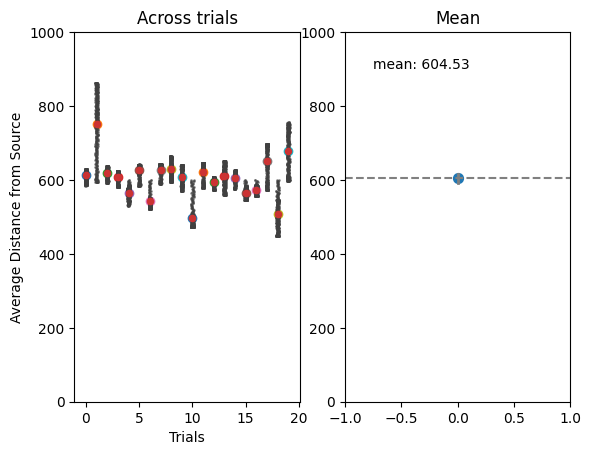

In [149]:
#@title Plot Iterative Trials
bin1 = []
plt.subplot(1,2,1)
mm = []
ss = []
for ind,ele in enumerate(mean_loop_out):
  #bin1.append(mean_loop[ele:ele+400])
  plt.scatter(ind,np.mean(ele))
  plt.scatter((ind-0.125)+(np.random.rand(time_duration)*0.25),ele,s=1,color=(0.25,0.25,0.25,0.5))
  plt.scatter(ind,np.mean(ele),s=20,color=(0.8,0.2,0.2))
  plt.ylabel('Average Distance from Source')
  plt.xlabel('Trials')
  plt.title('Across trials')
  plt.ylim([0,1000])
  mm.append(np.nanmean(ele))

plt.subplot(1,2,2)
plt.title('Mean')
plt.scatter(0,np.nanmean(mm),s=50)
plt.plot([-1,1],[np.nanmean(mm),np.nanmean(mm)],linewidth=1.5,linestyle='--',color=(0.5,0.5,0.5))
ss = np.nanstd(mm)/np.sqrt(len(mm))
plt.plot([0,0],[np.nanmean(mm)-ss,np.nanmean(mm)+ss],linewidth=2,color=(0.5,0.5,0.5))
plt.text(-0.75,900,'mean: '+str(np.round(np.nanmean(mm),2)))
plt.xlim([-1,1])
plt.ylim([0,1000])

(0.0, 1000.0)

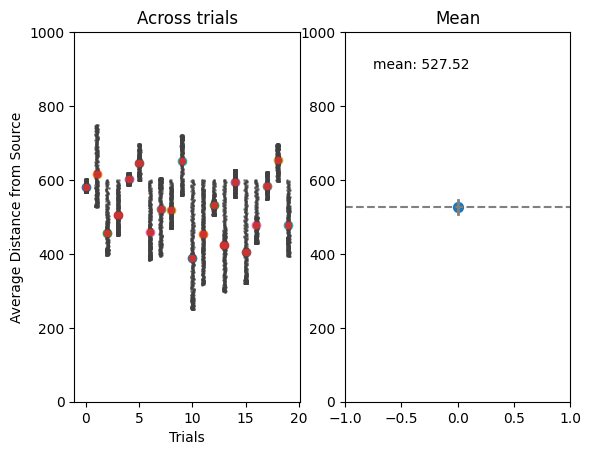

In [157]:
#@title Plot Iterative Trials
bin1 = []
plt.subplot(1,2,1)
mm = []
ss = []
for ind,ele in enumerate(mean_loop_out):
  #bin1.append(mean_loop[ele:ele+400])
  plt.scatter(ind,np.mean(ele))
  plt.scatter((ind-0.125)+(np.random.rand(time_duration)*0.25),ele,s=1,color=(0.25,0.25,0.25,0.5))
  plt.scatter(ind,np.mean(ele),s=20,color=(0.8,0.2,0.2))
  plt.ylabel('Average Distance from Source')
  plt.xlabel('Trials')
  plt.title('Across trials')
  plt.ylim([0,1000])
  mm.append(np.nanmean(ele))

plt.subplot(1,2,2)
plt.title('Mean')
plt.scatter(0,np.nanmean(mm),s=50)
plt.plot([-1,1],[np.nanmean(mm),np.nanmean(mm)],linewidth=1.5,linestyle='--',color=(0.5,0.5,0.5))
ss = np.nanstd(mm)/np.sqrt(len(mm))
plt.plot([0,0],[np.nanmean(mm)-ss,np.nanmean(mm)+ss],linewidth=2,color=(0.5,0.5,0.5))
plt.text(-0.75,900,'mean: '+str(np.round(np.nanmean(mm),2)))
plt.xlim([-1,1])
plt.ylim([0,1000])